# RR 간격으로 자르고 DTW계산

In [1]:
import os

os.chdir('/home/ubuntu/')
print(os.getcwd())

/home/ubuntu


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

# 데이터 정규화 함수
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Load the data
npy_data = np.load('hw/00028467_4.npy')
combined_data = np.load('hw/combined_leads.npy')

# Convert npy_data to a 1D array if it's 2D
if npy_data.ndim == 2 and npy_data.shape[0] == 1:
    npy_data = npy_data.flatten()

# Clean the npy_data (assuming a sampling rate, adjust as necessary)
npy_data_cleaned = nk.ecg_clean(npy_data, sampling_rate=250)

# Extract and clean Lead II from combined_data
lead_II_combined = combined_data[1, :]
lead_II_combined_cleaned = nk.ecg_clean(lead_II_combined, sampling_rate=500)

# Find R-peaks
_, rpeaks_npy = nk.ecg_peaks(npy_data_cleaned, sampling_rate=250)
_, rpeaks_combined = nk.ecg_peaks(lead_II_combined_cleaned, sampling_rate=500)

# Extract RR intervals and normalize
rr_intervals_npy = nk.ecg_segment(npy_data_cleaned, rpeaks_npy['ECG_R_Peaks'], sampling_rate=250)
rr_intervals_combined = nk.ecg_segment(lead_II_combined_cleaned, rpeaks_combined['ECG_R_Peaks'], sampling_rate=500)

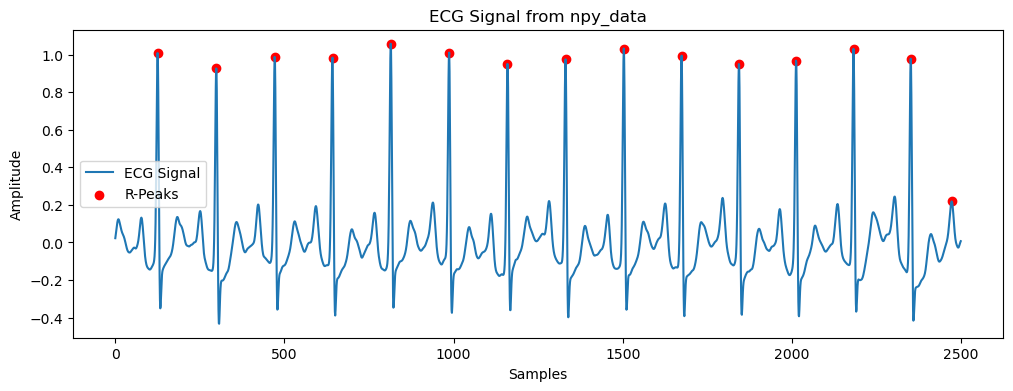

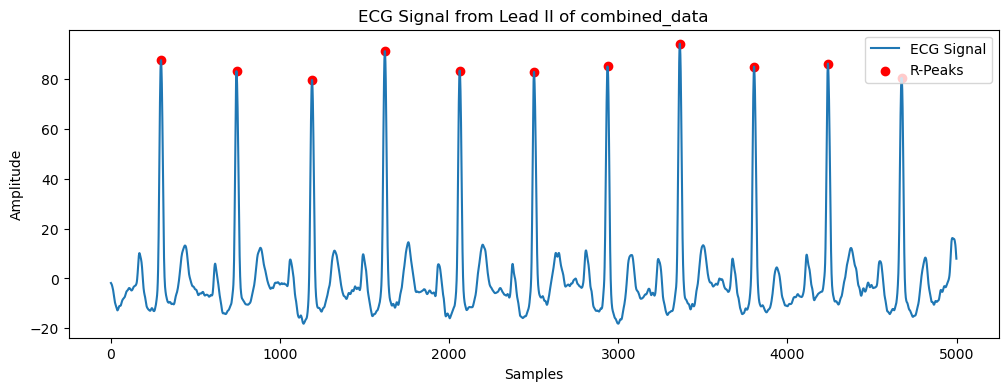

In [3]:
# 시각화를 위한 함수 정의
def plot_ecg_with_rpeaks(ecg_signal, rpeaks, title, sampling_rate):
    plt.figure(figsize=(12, 4))
    plt.plot(ecg_signal, label='ECG Signal')
    plt.scatter(rpeaks, ecg_signal[rpeaks], color='red', label='R-Peaks')
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# npy_data의 ECG 신호와 R-피크 시각화
plot_ecg_with_rpeaks(npy_data_cleaned, rpeaks_npy['ECG_R_Peaks'], 'ECG Signal from npy_data', sampling_rate=250)

# combined_data의 Lead II ECG 신호와 R-피크 시각화
plot_ecg_with_rpeaks(lead_II_combined_cleaned, rpeaks_combined['ECG_R_Peaks'], 'ECG Signal from Lead II of combined_data', sampling_rate=500)


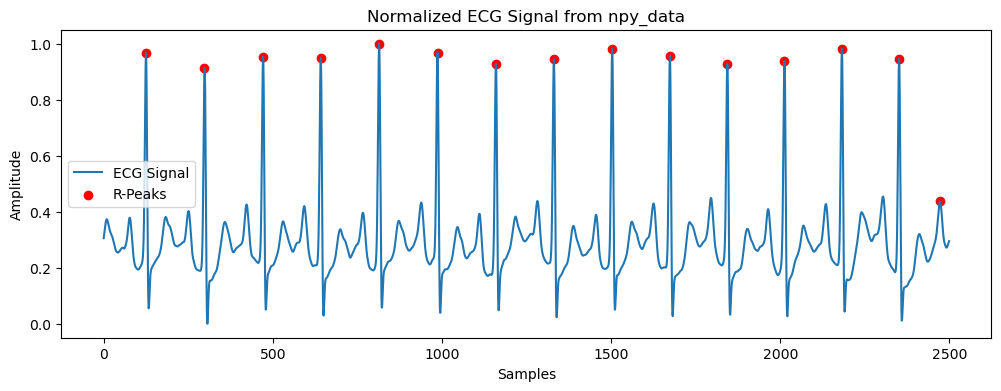

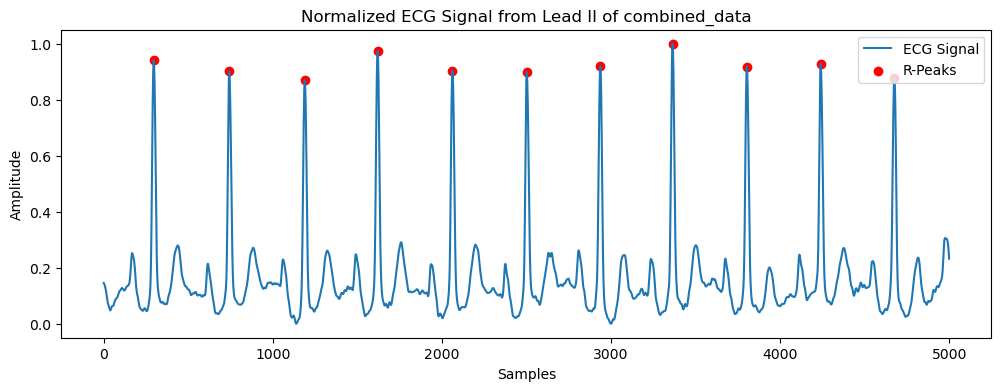

In [4]:
# 정규화 함수를 사용하여 데이터 정규화
npy_data_cleaned_normalized = normalize_data(npy_data_cleaned)
lead_II_combined_cleaned_normalized = normalize_data(lead_II_combined_cleaned)

# 정규화된 데이터와 R-피크를 시각화
plot_ecg_with_rpeaks(npy_data_cleaned_normalized, rpeaks_npy['ECG_R_Peaks'], 'Normalized ECG Signal from npy_data', sampling_rate=250)
plot_ecg_with_rpeaks(lead_II_combined_cleaned_normalized, rpeaks_combined['ECG_R_Peaks'], 'Normalized ECG Signal from Lead II of combined_data', sampling_rate=500)


In [5]:
print(npy_data_cleaned_normalized.shape)
print(lead_II_combined_cleaned_normalized.shape)

(2500,)
(5000,)


In [6]:
from scipy.interpolate import interp1d

# 신호를 재샘플링하는 함수
def resample_signal(signal, target_length):
    current_length = len(signal)
    interpolation_function = interp1d(np.linspace(0, 1, current_length), signal)
    return interpolation_function(np.linspace(0, 1, target_length))

# 두 신호를 동일한 길이로 재샘플링
target_length = min(len(npy_data_cleaned_normalized), len(lead_II_combined_cleaned_normalized))
npy_data_resampled = resample_signal(npy_data_cleaned_normalized, target_length)
lead_II_combined_resampled = resample_signal(lead_II_combined_cleaned_normalized, target_length)

# 재샘플링된 신호의 길이 확인
print(npy_data_resampled.shape)
print(lead_II_combined_resampled.shape)


(2500,)
(2500,)


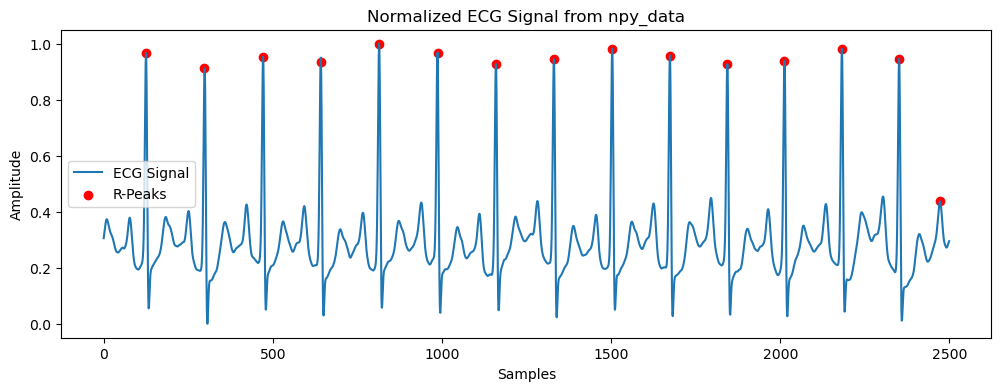

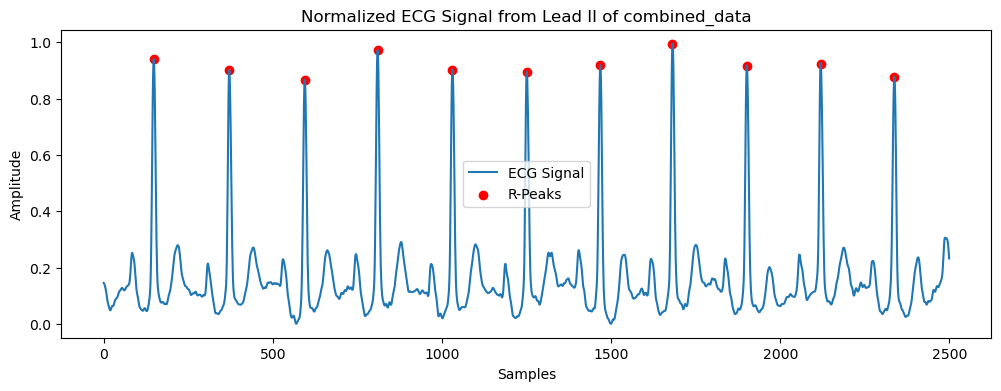

In [7]:
# R-피크 위치를 재조정하는 함수
def adjust_rpeaks(rpeaks, original_length, new_length):
    return (rpeaks / original_length * new_length).astype(int)

# R-피크 위치 재조정
rpeaks_npy_adjusted = adjust_rpeaks(rpeaks_npy['ECG_R_Peaks'], len(npy_data_cleaned_normalized), len(npy_data_resampled))
rpeaks_combined_adjusted = adjust_rpeaks(rpeaks_combined['ECG_R_Peaks'], len(lead_II_combined_cleaned_normalized), len(lead_II_combined_resampled))

# 재조정된 R-피크 위치와 함께 신호 시각화
plot_ecg_with_rpeaks(npy_data_resampled, rpeaks_npy_adjusted, 'Normalized ECG Signal from npy_data', sampling_rate=250)
plot_ecg_with_rpeaks(lead_II_combined_resampled, rpeaks_combined_adjusted, 'Normalized ECG Signal from Lead II of combined_data', sampling_rate=250)


In [8]:
lead_II_combined_resampled.shape


(2500,)

In [9]:
npy_data_resampled.shape

(2500,)

In [10]:
from dtaidistance import dtw


distance = dtw.distance(lead_II_combined_resampled, npy_data_resampled)
print(distance)

4.653919819756483
